In [1]:
import numpy as np
import cPickle        
import os
import gzip        
import math
import matplotlib.pyplot as plt

%matplotlib inline

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Using matplotlib backend: TkAgg


# First exercise: Classifying MNIST with MLPs
In this exercise you will implement a Neural Network (or MLP) and classify the MNIST digits with it.
MNIST is a "well hung" dataset that has been used a lot over the years to benchmark different classification algorithms. 
To learn more about it have a look here: http://yann.lecun.com/exdb/mnist/ .

# Data Loading
We first define a function for downloading and loading MNIST.
**WARNING**: Executing it will obviously use up some space on your machine ;). 

In [2]:
def mnist(datasets_dir = './data'):
    if not os.path.exists(datasets_dir):
        os.mkdir(datasets_dir)
    data_file = os.path.join(datasets_dir, 'mnist.pkl.gz')
    if not os.path.exists(data_file):
        print('... downloading MNIST from the web')
        try:
            import urllib
            urllib.urlretrieve('http://google.com')
        except AttributeError:
            import urllib.request as urllib
        url = 'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
        urllib.urlretrieve(url, data_file)

    print('... loading data')
    
    # Load the dataset
    f = gzip.open(data_file, 'rb')
    try:
        train_set, valid_set, test_set = cPickle.load(f, encoding="latin1")
    except TypeError:
        train_set, valid_set, test_set = cPickle.load(f)
    f.close()

    test_x, test_y = test_set
    test_x = test_x.astype('float32')
    test_x = test_x.astype('float32').reshape(test_x.shape[0], 1, 28, 28)
    test_y = test_y.astype('int32')
    valid_x, valid_y = valid_set
    valid_x = valid_x.astype('float32')
    valid_x = valid_x.astype('float32').reshape(valid_x.shape[0], 1, 28, 28)
    valid_y = valid_y.astype('int32')
    train_x, train_y = train_set
    train_x = train_x.astype('float32').reshape(train_x.shape[0], 1, 28, 28)
    train_y = train_y.astype('int32')
    rval = [(train_x, train_y), (valid_x, valid_y), (test_x, test_y)]
    print('... done loading data')
    
    return rval

# Neural Network Layers
We now define "bare bone" neural network layers.
The parts marked with **TODO** are where you should finish the implementation!
Conceptually we will implement the layers as follows:

Each layer has a constructor that takes an input layer plus some additional arguments such as layer size and the activation function name. The layer then uses the provided input layer to compute the layer dimensions, weight shapes, etc. and setup all auxilliary variables.

Each layer then has to provide three functions (as defined in the Layer class below): *output_shape()*, *fprop()* and *bprop()*. The output_shape function is used to figure out the shape for the next layer and the *fprop()/bprop()* functions are used to compute forward and backward passes through the network.

In [3]:
# start by defining simple helpers
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def sigmoid_d(x):
    # TODO ################
    # TODO: implement this!
    # TODO ################
    return sigmoid(x) * (1.0 - sigmoid(x))

def tanh(x):
    return np.tanh(x)

def tanh_d(x):
    # TODO ################
    # TODO: implement this!
    # TODO ################
    return 1.0 - (tanh(x))**2

def relu(x):
    return np.maximum(0.0, x)

def relu_d(x):
    # TODO ################
    # TODO: implement this!
    # TODO ################
    x[x >= 0.0] = 1.0
    x[x < 0.0] = 0.0
    return x

def softmax(x, axis=1):
    # to make the softmax a "safe" operation we will 
    # first subtract the maximum along the specified axis
    # so that np.exp(x) does not blow up!
    # Note that this does not change the output.  (Also called numeric stability)
    x_max = np.max(x, axis=axis, keepdims=True)
    x_safe = x - x_max
    e_x = np.exp(x_safe)
    return e_x / np.sum(e_x, axis=axis, keepdims=True)

def one_hot(labels):
    """
    This creates a one hot encoding from a flat vector:
    i.e. given y = [0,2,1]
    it creates y_one_hot = [[1,0,0], [0,0,1], [0,1,0]]
    """
    
    '''
    classes = np.unique(labels)
    n_classes = classes.size
    one_hot_labels = np.zeros(labels.shape + (n_classes, ))    
    for c in classes:
        one_hot_labels[labels == c, c] = 1
    
    return one_hot_labels
    '''
    
    # alternative way is to use np.eye function
    classes = np.unique(labels)
    n_classes = classes.size
    
    return np.eye(n_classes)[labels]

def unhot(one_hot_labels):
    """ Invert a one hot encoding, creating a flat vector """
    # Returns the indices of the maximum values along an axis.
    return np.argmax(one_hot_labels, axis=-1)    

# then define an activation function class
class Activation(object):
    
    def __init__(self, tname):        # self: refers to the newly created object
        if tname == 'sigmoid':
            self.act = sigmoid
            self.act_d = sigmoid_d
        elif tname == 'tanh':
            self.act = tanh
            self.act_d = tanh_d
        elif tname == 'relu':
            self.act = relu
            self.act_d = relu_d
        else:
            raise ValueError('Invalid activation function.')
    
    # self: refers to the instance whose method was called
    def fprop(self, input):        
        # we need to remember the last input
        # so that we can calculate the derivative with respect
        # to it later on
        self.last_input = input
        return self.act(input)
    
    # chain rule, matrix multiplication
    def bprop(self, output_grad):
        return output_grad * self.act_d(self.last_input)    


# define a base class for layers
class Layer(object):
    
    def fprop(self, input):
        """ 
        Calculate layer output for given input (forward propagation). 
        """
        raise NotImplementedError('This is an interface class, please use a derived instance')

    def bprop(self, output_grad):
        """ 
        Calculate input gradient and gradient 
        with respect to weights and bias (backpropagation). 
        """
        raise NotImplementedError('This is an interface class, please use a derived instance')

    def output_size(self):
        """ 
        Calculate size of this layer's output.
        input_shape[0] is the number of samples in the input.
        input_shape[1:] is the shape of the feature.
        """
        raise NotImplementedError('This is an interface class, please use a derived instance')


# define a base class for loss outputs
# an output layer can then simply be derived from both Layer and Loss 
class Loss(object):

    def loss(self, output, output_net):
        """ Calculate mean loss given real output and network output. """
        raise NotImplementedError('This is an interface class, please use a derived instance')

    def input_grad(self, output, output_net):
        """ Calculate input gradient given real output and network output. """
        raise NotImplementedError('This is an interface class, please use a derived instance')


# define a base class for parameterized things        
class Parameterized(object):
    
    def params(self):
        """ Return parameters (by reference) """
        raise NotImplementedError('This is an interface class, please use a derived instance')
    
    def grad_params(self):
        """ Return accumulated gradient with respect to params. """
        raise NotImplementedError('This is an interface class, please use a derived instance')


# define a container for providing input to the network
class InputLayer(Layer):
    
    def __init__(self, input_shape):
        if not isinstance(input_shape, tuple):
            raise ValueError("InputLayer requires input_shape as a tuple")
        self.input_shape = input_shape

    def output_size(self):
        return self.input_shape
    
    def fprop(self, input):
        return input
    
    def bprop(self, output_grad):
        return output_grad


class FullyConnectedLayer(Layer, Parameterized):
    """ 
    A standard fully connected hidden layer, as discussed in the lecture.
    """
    
    def __init__(self, input_layer, num_units, 
                 init_stddev, activation_fun=Activation('relu')):
        self.num_units = num_units
        self.activation_fun = activation_fun
        
        # the input shape will be of size (batch_size, num_units_prev) 
        # where num_units_prev is the number of units in the input (previous) layer
        self.input_shape = input_layer.output_size()
        
        # TODO ################################
        # TODO: implement weight initialization
        # TODO ################################
        # this is the weight matrix it should have shape: (num_units_prev, num_units)
        #self.W = np.random.standard_normal((self.input_shape[1], num_units)) * init_stddev
        self.W = init_stddev * np.random.normal(0.0, 1.0, [self.input_shape[1], num_units]) 
        
        # and this is the bias vector of shape: (num_units) 
        #self.b = np.random.standard_normal((1, self.num_units))
        self.b = np.zeros(num_units)
        
        # create dummy variables for parameter gradients
        # no need to change these here!
        self.dW = None
        self.db = None
    
    def output_size(self):
        return (self.input_shape[0], self.num_units)
    
    def fprop(self, input):
        # TODO ################################################
        # TODO: implement forward propagation
        # NOTE: you should also handle the case were 
        #       activation_fun is None (meaning no activation)
        #       then this is simply a linear layer
        # TODO ################################################
        # again, you want to cache the last_input for the bprop implementation below!
        
        # raise NotImplementedError("You should implement this!")
        # return np.zeros(self.output_size)
        
        self.last_input = input
        
        if self.activation_fun is None:
            return input.dot(self.W) + self.b
        else:
            return self.activation_fun.fprop(input.dot(self.W) + self.b)
 
    def bprop(self, output_grad):
        """ Calculate input gradient (backpropagation). """
        # TODO ###############################
        # TODO: implement backward propagation
        # TODO ###############################
        
        # HINT: you may have to divide the weights by n (batch_size)
        #       to make gradient checking work 
        #       (since you want to divide the loss by number of inputs)
        
        n = output_grad.shape[0]
        
        # accumulate gradient wrt. the parameters first
        # we will need to store these to later update
        # the network after a few forward backward passes
        # the gradient wrt. W should be stored as self.dW
        # the gradient wrt. b should be stored as self.db
        if self.activation_fun is not None:
            dhidden = self.activation_fun.bprop(output_grad)
        else:
            dhidden = output_grad
            
        self.dW = np.dot(self.last_input.T, dhidden)
        self.db = np.sum(dhidden, axis=0)
        
        self.dW /= n
        self.db /= n
        
        # the gradient wrt. the input should be calculated here
        grad_input = np.zeros_like(self.last_input)        
        grad_input = np.dot(dhidden, self.W.T)
        
        return grad_input
        
    def params(self):
        return self.W, self.b

    def grad_params(self):
        return self.dW, self.db

    
# finally we specify the interface for output layers which are layers 
# that also have a loss function we will implement two output layers:
# a Linear, and Softmax (Logistic Regression) layer

# The difference between output layers and normal layers is that they 
# will be called to compute the gradient of the loss through input_grad(). 
# bprop will never be called on them!
class LinearOutput(Layer, Loss):
    """ 
    A simple linear output layer that uses a squared loss (e.g. should be used for regression)
    """
    def __init__(self, input_layer):
        self.input_size = input_layer.output_size()
        
    def output_size(self):
        return (1, )
        
    def fprop(self, input):
        return input

    def bprop(self, output_grad):
        raise NotImplementedError(
            'LinearOutput should only be used as the last layer of a Network'
            + ' bprop() should thus never be called on it!'
        )
    
    def input_grad(self, Y, Y_pred):
        # TODO ####################################
        # TODO: implement gradient of squared loss
        # TODO ####################################
        # return np.zeros_like(Y_pred) #FIXME

        return (Y_pred - Y)

    def loss(self, Y, Y_pred):
        loss = np.sum(0.5 * np.square(Y - Y_pred)) / Y.shape[0]
        
        return loss


class SoftmaxOutput(Layer, Loss):
    """ 
    A softmax output layer that calculates the negative log likelihood as loss
    and should be used for classification.
    """
    
    def __init__(self, input_layer):
        self.input_size = input_layer.output_size()
        
    def output_size(self):
        return (1, )
    
    def fprop(self, input):
        return softmax(input)
    
    def bprop(self, output_grad):
        raise NotImplementedError(
            'SoftmaxOutput should only be used as the last layer of a Network'
            + ' bprop() should thus never be called on it!'
        )
    
    def input_grad(self, Y, Y_pred):    
        # TODO #######################################################
        # TODO: implement gradient of the negative log likelihood loss
        # TODO #######################################################
        # HINT: since this would involve taking the log 
        #       of the softmax (which is np.exp(x)/np.sum(np.exp(x), axis=1))
        #       this gradient computation can be simplified a lot! 
        # return np.zeros_like(Y_pred) #FIXME
        
        return Y_pred - Y

    # one_hot encoding, minimize the cross-entropy loss
    def loss(self, Y, Y_pred):    
        
        # Assume one-hot encoding of Y
        out = Y_pred       
        
        # to make the loss numerically stable you may want to add an epsilon in the log;
        eps = 1e-10
        
        # TODO ####################################
        # calculate negative log likelihood
        # TODO ####################################
        # loss = np.zeros_like(out) #FIXME 
        
        loss = -np.sum(Y * np.log(out + eps)) / Y.shape[0]
        return loss 

# Neural Network class
With all layers in place (and properly implemented by you) we can finally define a neural network.
For our purposes a neural network is simply a collection of layers which we will cycle through and on which we will call *fprop* and *bprop* to compute partial derivatives with respect to the input and the parameters.

Pay special attention to the *check_gradients()* function in which you should implement automatic differentiation. This function will become your best friend when checking the correctness of your implementation.

In [12]:
class NeuralNetwork:
    """ Our Neural Network container class."""
    def __init__(self, layers, reg):    # Add regularization term
        self.layers = layers
        self.reg = reg
        
    def _loss(self, X, Y):    
        Y_pred = self.predict(X)
        data_loss = self.layers[-1].loss(Y, Y_pred)
        reg_loss = 0.0
        for layer in self.layers:
            if isinstance(layer, Parameterized):
                reg_loss += 0.5 * self.reg * np.sum(np.square(layer.params()[0]))
                
        return data_loss + reg_loss

    def predict(self, X):
        """ Calculate an output Y for the given input X. """
        # TODO ##########################################
        # TODO: implement forward pass through all layers
        # TODO ##########################################
        # Y_pred = 0.
        for l, _ in enumerate(self.layers):
            X = self.layers[l].fprop(X)
        Y_pred = X
        return Y_pred
    
    def backpropagate(self, Y, Y_pred, upto=0):    
        """ 
        Backpropagation of partial derivatives through the complete network up to layer 'upto'
        """
        next_grad = self.layers[-1].input_grad(Y, Y_pred)    # (64, 10)
        
        # TODO ##########################################
        # TODO: implement backward pass through all layers
        # TODO ##########################################
        for i in range(len(self.layers)-2, upto-1, -1):
            next_grad = self.layers[i].bprop(next_grad)    
        return next_grad
    
    def classification_error(self, X, Y):    
        """ 
        Calculate error on the given data assuming they are classes that should be predicted. 
        """
        Y_pred = unhot(self.predict(X))         # for example [9, 1, 1, 2, 3]
        error = Y_pred != Y
        return np.mean(error)
    
    def sgd_epoch(self, X, Y, learning_rate, batch_size):    # one_hot encoding
        n_samples = X.shape[0]
        n_batches = n_samples // batch_size
        for b in range(n_batches):
            # TODO #####################################
            # Implement stochastic gradient descent here
            # TODO #####################################
            # start by extracting a batch from X and Y
            # (you can assume the inputs are already shuffled)
            sample_indices = np.random.choice(np.arange(n_samples), batch_size)
            X_batch = X[sample_indices]
            Y_batch = Y[sample_indices]

            # TODO: then forward and backward propagation + updates
            # HINT: layer.params() returns parameters *by reference*
            #       so you can easily update in-place
            Y_batch_pred = self.predict(X_batch)
            next_grad = self.backpropagate(Y_batch, Y_batch_pred, 0)
            
            for layer in self.layers:
                if isinstance(layer, Parameterized):
                    for param, grad in zip(layer.params(), layer.grad_params()):
                        param += -learning_rate * grad
    
    def gd_epoch(self, X, Y, learning_rate):        # one_hot encoding
        # TODO ##################################################
        # Implement batch gradient descent here
        # A few hints:
        #   There are two strategies you can follow:
        #   Either shove the whole dataset throught the network
        #   at once (which can be problematic for large datasets)
        #   or run through it batch wise as in the sgd approach
        #   and accumulate the gradients for all parameters as
        #   you go through the data. Either way you should then
        #   do one gradient step after you went through the
        #   complete dataset!
        # TODO ##################################################
        Y_pred = self.predict(X)
        next_grad = self.backpropagate(Y, Y_pred, 0)
        
        for layer in self.layers:
            if isinstance(layer, Parameterized):
                for param, grad in zip(layer.params(), layer.grad_params()):
                    param += -learning_rate * grad
    
    def train(self, X_train, y_train, X_val, y_val, learning_rate=0.1, 
              max_epochs=100, batch_size=64, descent_type="sgd", y_one_hot=True):
        """ 
        Train network on the given data. 
        """
        n_samples = X_train.shape[0]
        n_batches = n_samples // batch_size
        
        # store the (train, validation) loss and error
        train_loss = np.zeros(max_epochs + 1)
        train_error = np.zeros(max_epochs + 1)
        
        val_loss = np.zeros(max_epochs + 1)
        val_error = np.zeros(max_epochs + 1)
        
        if y_one_hot:
            Y_train = one_hot(y_train)
            Y_val = one_hot(y_val)
        else:
            Y_train = y_train
            Y_val = y_val
        
        print("-------------------starting training-------------------")
        
        for e in range(max_epochs + 1):
            if descent_type == "sgd":
                self.sgd_epoch(X_train, Y_train, learning_rate, batch_size)
            elif descent_type == "gd":
                self.gd_epoch(X_train, Y_train, learning_rate)
            else:
                raise NotImplementedError("Unknown gradient descent type {}".format(descent_type))

            # Output error on the training data (y_train is not one_hot encoding)
            train_loss[e] = self._loss(X_train, Y_train)    
            train_error[e] = self.classification_error(X_train, y_train)    
            print('epoch {:.4f}, loss {:.4f}, train error {:.4f}'.format(e, train_loss[e], train_error[e]))
            
            # TODO ##################################################
            # compute error on validation data:
            # simply make the function take validation data as input
            # and then compute errors here and print them
            # TODO ##################################################
            val_loss[e] = self._loss(X_val, Y_val)
            val_error[e] = self.classification_error(X_val, y_val)
            print('epoch {:.4f}, loss {:.4f}, validation error {:.4f}'.format(e, val_loss[e], val_error[e]))
        
        return train_loss, train_error, val_loss, val_error
    
    def check_gradients(self, X, Y):
        """ 
        Helper function to test the parameter gradients for correctness. 
        """
        for l, layer in enumerate(self.layers):
            if isinstance(layer, Parameterized):            # FullyConnectedLayer
                print('checking gradient for layer {}'.format(l))
                for p, param in enumerate(layer.params()):
                    # we iterate through all parameters
                    param_shape = param.shape
                    
                    # define functions for conveniently swapping out parameters of this specific layer 
                    # and computing loss and gradient with these changed parameters
                    def output_given_params(param_new):
                        """ 
                        A function that will compute the output of the network given a set of parameters
                        """
                        # copy provided parameters
                        param[:] = np.reshape(param_new, param_shape)
                        
                        # return computed loss
                        return self._loss(X, Y)

                    def grad_given_params(param_new):
                        """
                        A function that will compute the gradient of the network given a set of parameters
                        """
                        # copy provided parameters
                        param[:] = np.reshape(param_new, param_shape)
                        
                        # Forward propagation through the net
                        Y_pred = self.predict(X)
                        
                        # Backpropagation of partial derivatives
                        self.backpropagate(Y, Y_pred, upto=l)
                        
                        # return the computed gradient 
                        return np.ravel(self.layers[l].grad_params()[p])

                    # let the initial parameters be the ones that
                    # are currently placed in the network and flatten them
                    # to a vector for convenient comparisons, printing etc.
                    
                    # the copy will not change even the original changes (W, b)
                    param_init = np.ravel(np.copy(param))    
                    
                    # TODO ####################################
                    # TODO compute the gradient with respect to
                    #      the initial parameters in two ways:
                    #      1) with grad_given_params()
                    #      2) with finite differences 
                    #         using output_given_params()
                    #         (as discussed in the lecture)
                    #      if your implementation is correct 
                    #      both results should be epsilon close
                    #      to each other!
                    # TODO ####################################
                    epsilon = 1e-4
                    
                    # making sure your gradient checking routine itself 
                    # has no errors can be a bit tricky. To debug it
                    # you can "cheat" by using scipy which implements
                    # gradient checking exactly the way you should!
                    # To do that simply run the following here:
                    
                    """
                    # approach 1
                    import scipy.optimize
                    err = scipy.optimize.check_grad(output_given_params, grad_given_params, param_init)
                    print('diff {:.2e}'.format(err))
                    assert (err < epsilon)
                    """
                    
                    # approach 2
                    loss_base = output_given_params(param_init)    # return the loss
                    
                    # TODO this should hold the gradient calculated through bprop
                    gparam_bprop = grad_given_params(param_init)
                    
                    # TODO this should hold the gradient calculated through finite differences
                    gparam_fd = np.zeros_like(param_init)
                    for i in range(len(param_init)):
                        param_init[i] += epsilon                                              
                        loss_after     = output_given_params(param_init)                       
                        gparam_fd[i]   = (loss_after - loss_base) / epsilon
                        param_init[i] -= epsilon
                    
                    # calculate difference between them
                    if not None in gparam_bprop and gparam_fd is not None:    # ???
                        err = np.mean(np.abs(gparam_bprop - gparam_fd))
                        print('diff {:.2e}'.format(err))
                        assert (err < epsilon)
                        
                    # reset the parameters to their initial values
                    param[:] = np.reshape(param_init, param_shape)

# Gradient Checking
After implementing everything it is always a good idea to setup some layers and perform gradient
checking on random data. **Note** that this is only an example! It is not a useful network architecture ;). We also expect you to play around with this to test all your implemented components.

In [13]:
input_shape = (5, 10)
n_labels = 10
layers = [InputLayer(input_shape)]

layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=128,
                init_stddev=0.1,
                activation_fun=Activation('relu')
))
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=64,
                init_stddev=0.1,
                activation_fun=Activation('tanh')
))
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=n_labels,
                init_stddev=0.1,
                activation_fun=Activation('relu')
))
layers.append(SoftmaxOutput(layers[-1]))
#layers.append(LinearOutput(layers[-1]))

nn = NeuralNetwork(layers, reg=0.0)        # gradient check without L2 regularization

In [14]:
# create random data
X = np.random.normal(size=input_shape)
# and random labels
Y = np.zeros((input_shape[0], n_labels))
for i in range(Y.shape[0]):
    idx = np.random.randint(n_labels)
    Y[i, idx] = 1.

In [15]:
nn.check_gradients(X, Y)

checking gradient for layer 1
diff 2.11e-06
diff 4.17e-06
checking gradient for layer 2


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:230: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


diff 3.17e-08
diff 5.52e-07
checking gradient for layer 3
diff 1.48e-07
diff 3.02e-06


# Training on MNIST
Finally we can let our network run on the MNIST dataset!

First load the data and reshape it.

In [16]:
# load the data
Dtrain, Dval, Dtest = mnist()
X_train, y_train = Dtrain
X_val, y_val = Dval
X_test, y_test = Dtest

# Downsample training data to make it a bit faster for testing this code
n_train_samples = 50000
train_idxs = np.random.permutation(X_train.shape[0])[:n_train_samples]
X_train = X_train[train_idxs]
y_train = y_train[train_idxs]

... loading data
... done loading data


*Dtrain* contains 50k images which are of size 28 x 28 pixels. Hence:

In [17]:
print("X_train shape: {}".format(np.shape(X_train)))
print("y_train shape: {}".format(np.shape(y_train)))

X_train shape: (50000, 1, 28, 28)
y_train shape: (50000,)


y_train will automatically be converted in the *train()* function to one_hot encoding.


But we need to reshape X_train, as our Network expects flat vectors of size 28*28 as input!

In [18]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

print("Reshaped X_train size: {}".format(X_train.shape))
print("Reshaped X_val size: {}".format(X_val.shape))
print("Reshaped X_test size: {}".format(X_test.shape))

Reshaped X_train size: (50000, 784)
Reshaped X_val size: (10000, 784)
Reshaped X_test size: (10000, 784)


Ah, much better ;-)! 

Now we can finally really start training a Network!


I pre-defined a small Network for you below. Again this is not really a good default and will not produce state of the art results. Please play around with this a bit. See how different activation functions and training procedures (gd / sgd) affect the result.

In [19]:
import time

# Setup a small MLP / Neural Network
# we can set the first shape to None here to indicate that
# we will input a variable number inputs to the network
input_shape = (None, 28*28)
layers = [InputLayer(input_shape)]
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=128,
                init_stddev=0.01,
                activation_fun=Activation('relu')
))
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=64,
                init_stddev=0.01,
                activation_fun=Activation('relu')
))
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=10,
                init_stddev=0.01,
                # last layer has no nonlinearity 
                # (softmax will be applied in the output layer)
                activation_fun=None
))
layers.append(SoftmaxOutput(layers[-1]))
#layers.append(LinearOutput(layers[-1]))

nn = NeuralNetwork(layers, reg=1e-5)
# Train neural network
t0 = time.time()
train_loss, train_error, val_loss, val_error = nn.train(X_train, y_train, X_val, y_val, 
                                                        learning_rate=0.1, max_epochs=20, 
                                                        batch_size=64, descent_type="sgd", y_one_hot=True)
t1 = time.time()
print('Duration: {:.1f}s'.format(t1-t0))

-------------------starting training-------------------
epoch 0.0000, loss 0.4503, train error 0.1298
epoch 0.0000, loss 0.4140, validation error 0.1180
epoch 1.0000, loss 0.2585, train error 0.0737
epoch 1.0000, loss 0.2437, validation error 0.0689
epoch 2.0000, loss 0.1862, train error 0.0529
epoch 2.0000, loss 0.1828, validation error 0.0513
epoch 3.0000, loss 0.1368, train error 0.0399
epoch 3.0000, loss 0.1434, validation error 0.0388
epoch 4.0000, loss 0.1004, train error 0.0288
epoch 4.0000, loss 0.1190, validation error 0.0349
epoch 5.0000, loss 0.0839, train error 0.0242
epoch 5.0000, loss 0.1063, validation error 0.0322
epoch 6.0000, loss 0.0762, train error 0.0221
epoch 6.0000, loss 0.1085, validation error 0.0322
epoch 7.0000, loss 0.0575, train error 0.0167
epoch 7.0000, loss 0.0935, validation error 0.0268
epoch 8.0000, loss 0.0488, train error 0.0140
epoch 8.0000, loss 0.0893, validation error 0.0246
epoch 9.0000, loss 0.0432, train error 0.0119
epoch 9.0000, loss 0.0931

# Figure out a reasonable Network that achieves good performance
As the last part of this task, setup a network that works well and gets reasonable accuracy, say ~ 1-3 percent error on the **validation set**. 
Train this network on the complete data and compute the **test error**. 

Once you have done this, visualize a few digits from the test set that the network gets right as well as a few that the network gets wrong!

In [20]:
# Compute the test error
nn.classification_error(X_test, y_test)

0.021899999999999999

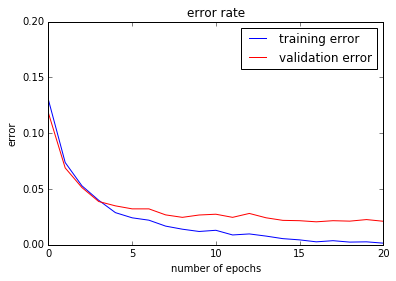

In [30]:
# plotting the error rate
plt.plot(np.arange(21), train_error, color='blue', label='training error')
plt.plot(np.arange(21), val_error, color='red', label='validation error')
plt.ylim([0.0, 0.2])
plt.xlabel("number of epochs")
plt.ylabel("error")
plt.legend(['training error', 'validation error'], loc='upper right')
plt.title("error rate")
plt.show()

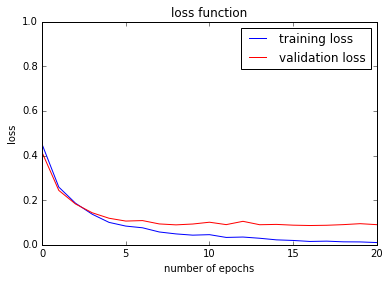

In [31]:
# plotting the loss function
plt.plot(np.arange(21), train_loss, color='blue', label='training loss')
plt.plot(np.arange(21), val_loss, color='red', label='validation loss')
plt.ylim([0.0, 1.0])
plt.xlabel("number of epochs")
plt.ylabel("loss")
plt.legend(['training loss', 'validation loss'], loc='upper right')
plt.title("loss function")
plt.show()

In [32]:
# Visualize a few digits from the test set (correctly classified, wrongly classified)
X_200 = X_test[:200]
y_200 = y_test[:200]
P_200 = unhot(nn.predict(X_200))
print "y_200: ", y_200
print "P_200: ", P_200

y_200:  [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1 3 4 7 2 7
 1 2 1 1 7 4 2 3 5 1 2 4 4 6 3 5 5 6 0 4 1 9 5 7 8 9 3 7 4 6 4 3 0 7 0 2 9
 1 7 3 2 9 7 7 6 2 7 8 4 7 3 6 1 3 6 9 3 1 4 1 7 6 9 6 0 5 4 9 9 2 1 9 4 8
 7 3 9 7 4 4 4 9 2 5 4 7 6 7 9 0 5 8 5 6 6 5 7 8 1 0 1 6 4 6 7 3 1 7 1 8 2
 0 2 9 9 5 5 1 5 6 0 3 4 4 6 5 4 6 5 4 5 1 4 4 7 2 3 2 7 1 8 1 8 1 8 5 0 8
 9 2 5 0 1 1 1 0 9 0 3 1 6 4 2]
P_200:  [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1 3 4 7 2 7
 1 2 1 1 7 4 2 3 5 1 2 4 4 6 3 5 5 6 0 4 1 9 5 7 8 9 3 7 4 6 4 3 0 7 0 2 9
 1 7 3 2 9 7 7 6 2 7 8 4 7 3 6 1 3 6 9 3 1 4 1 7 6 9 6 0 5 4 5 9 2 1 9 4 8
 7 3 9 7 4 4 4 9 2 5 4 7 6 7 9 0 5 8 5 6 6 5 7 8 1 0 1 6 4 6 7 3 1 7 1 8 2
 0 3 9 9 5 5 1 5 6 0 3 4 4 6 5 4 6 5 4 5 1 4 4 7 2 3 2 7 1 8 1 8 1 8 5 0 8
 9 2 5 0 1 1 1 0 9 0 3 1 6 4 2]


In [33]:
nn.classification_error(X_200, y_200)

0.01

In [34]:
y_200[149], P_200[149], y_200[151], P_200[151]

(2, 3, 9, 9)

Visualizing some selected digits from **test set** which are **correctly** classified, as well as some digits that are **wrongly** classified.

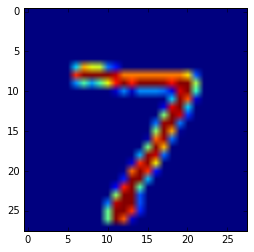

In [37]:
# correctly classified 1
plt.imshow(np.reshape(X_test[0], (28, 28)))

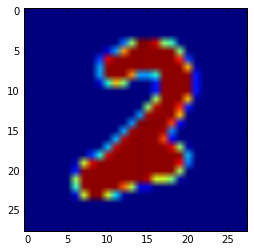

In [38]:
# correctly classified 2
plt.imshow(np.reshape(X_test[199], (28, 28)))

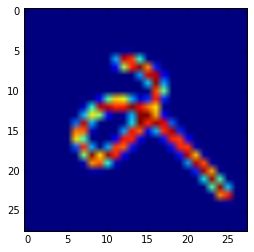

In [40]:
# wrongly classified 1
plt.imshow(np.reshape(X_test[149], (28, 28)))

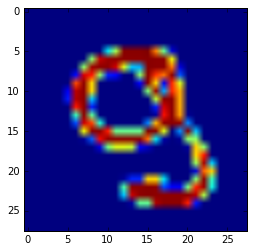

In [41]:
# wrongly classified 1
plt.imshow(np.reshape(X_test[151], (28, 28)))